# AI Learns to play Dino game!

In [1]:
# Importing Libraries

# Bread and butter
import numpy as np
import matplotlib.pyplot as plt

# Importing Selenium to control the browser
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options

# To use our keyboard
import pyautogui

# To help me become Doctor Strange
import time

# Because I can't do Image processing myself
import cv2 

# Deep Learning Libraries
import torch
import torch.nn as nn
import torch.optim as optim

# Deque for storing experiences
from collections import deque

# Just a random import
import random

# To make for loops look cool
from tqdm import tqdm

In [15]:
# Pur environment class which is used to play the game
class Environment():

    def __init__(self, device="cpu", chrome_path=".//Driver/chromedriver.exe"):
        self.done = False
        self.device = device
        self.initialize_chrome(chrome_path)
        
    def initialize_chrome(self, chrome_path):
        chrome_options = Options()
        chrome_options.add_argument("start-maximized")
        chrome_options.add_argument("disable-infobars")
        chrome_options.add_argument("--mute-audio")
        self.driver = webdriver.Chrome(chrome_path, chrome_options=chrome_options)
        
    def reset(self, game_url="chrome://dino"):
        try:
            self.driver.get(game_url)
        except:
            pass
    
    def start(self):
        pyautogui.press("up")

    # Hard stop
    def close_all(self):
        self.driver.close()
        self.driver.quit()
        try:
            os.system("cmd /c taskkill /F /IM chromedriver.exe")
        except:
            print("No tasks found!")
    

    def get_screenshot(self, screenshot_path=".//Screenshots/"):
        current_state = []
        for i in range(1, 5):
            file_name = screenshot_path + str(i) + '.jpg'
            screenshot = pyautogui.screenshot(region=(0, 400, 1920, 330))
            screenshot.save(file_name)
            image_tensor = self.process_image(file_name)
            current_state.append(image_tensor)
        current_state = torch.cat(current_state).unsqueeze(0).to(self.device)
        return current_state

    def process_image(self, image_file):
        image = cv2.imread(image_file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image[image>255] = 255
        image = cv2.resize(image, (256, 128))
        image = cv2.Canny(image, threshold1=100, threshold2=200)
        image = np.reshape(image, (1, 256, 128))
        return self.image_to_tensor(image)

    def image_to_tensor(self, image):
        image = image.astype(np.float32)
        image_tensor = torch.from_numpy(image)
        image_tensor = image_tensor.to(self.device, dtype=torch.float32)
        return image_tensor


    def jump(self):
        pyautogui.keyDown("up")
        time.sleep(0.15)
        pyautogui.keyUp("up")


    def duck(self):
        pyautogui.keyDown("down")
        time.sleep(0.20)
        pyautogui.keyUp("down")


    def do_nothing(self):
        pass


    def take_action(self, action):
        if action == 0:
            self.jump()
        elif action == 1:
            self.duck()
        elif action == 2:
            self.do_nothing()
        
        state = self.get_screenshot()
        score = self.get_score()
        reward = 1 + score*(1e-2) 
        done = False
        
        if self.is_crashed():
            reward = -(11 + (1e+2)/score)
            done = True
            
        return state, reward, done
        
        
    def get_score(self):
        score_array = self.driver.execute_script("return Runner.instance_.distanceMeter.digits")
        score = "".join(score_array)
        return int(score)
        
        
    def view_screenshots(self, images):
        # images are of the shape (1, 4, 256, 128)
        images = torch.reshape(images, shape=(4, 128, 256))
        
        fig, ax = plt.subplots(2, 2, figsize=(14, 14))
        x = 0
        for i in range(2):
            for j in range(2):
                ax[i][j].imshow(images[x], cmap="gray")
                ax[i][j].set_title(f"Screenshot #{x}")
                x += 1
        
                
    def is_crashed(self):
        return self.driver.execute_script("return Runner.instance_.crashed")

In [16]:
class DinoNetwork(nn.Module):
    def __init__(self):
        super(DinoNetwork, self).__init__()
        # First Conv Layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=32, kernel_size=5, stride=3),
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=3),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 64, 3, 3),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(2304, 64),
            nn.ReLU()
            # nn.BatchNorm1d(2304)
        )

        self.fc2 = nn.Sequential(
            nn.Linear(64, 3),
            nn.ReLU()
            
        )

    def forward(self, inputs):
        # print(f"Dimensions of input are {inputs.shape}")
        x = self.conv1(inputs)
        # print(f"Dimensions after 1st Conv Layer are {x.shape}")
        x = self.conv2(x)
        x = self.conv3(x)
        # We will now flatten the layers
        # Calculated using this below line
        x = x.flatten(start_dim=1, end_dim=-1)
        # print(f"After flattening, shape is {x.shape}")
        x = self.fc1(x)
        x = self.fc2(x)
        return x
    




In [17]:
# Some Utlitity functions

# Save a model
def save_model(model_values):
    """
    Model Values is a dictionary of the following format
    dict = {
        'model_dict': policy_net.state_dict(),
        'optimizer_dict': optimizer.state_dict(),
        'epsilon': epsilon
    }
    """
    f_path = ".//v2_models/model.pt"
    torch.save(model_values, f_path)
    

def load_model(model_values_path, model, optimizer):
    model_values = torch.load(model_values_path)
    model.load_state_dict(model_values['state_dict'])
    optimizer.load_state_dict(model_values['optimizer'])
    epsilon = model_values['epsilon']
    return model, optimizer, epsilon
    
    
# Initializing weights
def init_weights(m):
    if type(m) == nn.Conv2d or type(m) == nn.Linear:
        # Kaimig Uniform initialization is used for Relu Activation. It's mostly known as 'He weight initialization'.
        torch.nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')

In [18]:
# Defining Constants
batch_size = 128

# Gamma (Discount rate for future rewards)
gamma = 0.95

# Exploration rate
epsilon_start = 1
epsilon = 1

# Decay rate for Epsilon
epsilon_decay = 0.995

# Minimum Epsilon
epsilon_min = 0.01

# Updating the Target Q Network after these many episodes
target_update = 40

# Selecting the device for the iterations
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Setting loss criteria
criterion = nn.MSELoss()

# Setting the learning rate
lr = 1e-6

# Setting memory size for replay memory
replay_memory_size = 100_000

# Initalizing deque for storing experiences
replay_memory = deque()

# Setting the Number of episodes
num_episodes = 500

# Defining our models
policy_net = DinoNetwork().to(device)
policy_net.apply(init_weights)

target_net = DinoNetwork().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

# Optimizer
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr) 

#Setting number of actions
n_actions = 3

In [28]:
agent_loss = []
epsilon_trend=[]
env = Environment(device=device)
def train(policy_net, target_net, optimizer, epsilon, resume_training=False, model_path=None, device='cpu'):
    # If the parameter 'resume_training' is set to True, we have to load a pre-trained model
    if resume_training:
        target_net, optimizer, epsilon = load_model(model_path, target_net, optimizer)
        policy_net.load_state_dict(target_net.state_dict())
        target_net.eval()
        for state in optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.to(device)    
    
    # Training loop
    for episode in tqdm(range(num_episodes)):
        env.reset()
        env.jump()
        done = False

        # Sleep time till the first obstacle arrives
        time.sleep(4)
        state = env.get_screenshot()
        while not done:
            random_number = random.random()

            if random_number <= epsilon: # Randomly explore
                action = random.randrange(n_actions)
            else: # Predict the action
                q_values = target_net(state) 
                action = torch.argmax(q_values)

            # Get experience from the environment
            next_state, reward, done = env.take_action(action)
            action_tensor = torch.tensor(action, dtype=torch.int64, device=device)
            reward_tensor = torch.tensor(reward, dtype=torch.int16, device=device)
            done_tensor = torch.tensor(done, dtype=torch.bool, device=device)

            if len(replay_memory) > replay_memory_size:
                replay_memory.popleft()

            replay_memory.append((state, action_tensor, reward_tensor, next_state, done_tensor))
            
        # Sufficient data has been gathered to train the model
        if len(replay_memory) > batch_size:
            minibatch = random.sample(replay_memory, batch_size)

            # Output Value placeholder (batch_size*number of actions)
            targets = torch.zeros((batch_size, 3)).to(device)
            prediction = torch.zeros((batch_size, 3)).to(device)
            states = torch.zeros((batch_size))
            
            for i in range(len(minibatch)):
                state = minibatch[i][0]
                action = minibatch[i][1]
                reward = minibatch[i][2]
                next_state = minibatch[i][3]
                done = minibatch[i][4]
                targets[i] = target_net(state)
                prediction[i] = target_net(state)

                if done:
                    targets[i, action] = reward
                else:
                    targets[i, action] = reward + gamma*torch.max(target_net(next_state))

            # print(f"Sample prediction: {prediction.data}")
            # print(f"Sample Target: {targets.data}")
            loss = criterion(prediction, targets)
            loss.backward()
            optimizer.step()
            state = next_state
            
            # Recording loss for scientific purposes
            agent_loss.append((loss/batch_size).item())

            # Saving our model after 150 episodes
            if episode % 150 == 0:
                model_values = {
                    'state_dict': target_net.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'epsilon': epsilon
                }
                save_model(model_values)

            # Updating target_net after a pre-determined number of episodes
            if episode % target_update == 0:
                target_net.load_state_dict(policy_net.state_dict())


        # Decaying epsilon to promote exploitation
        epsilon = max(epsilon*epsilon_decay, epsilon_min)
        epsilon_trend.append(epsilon)
        
        
        
    

D:\Programming\Python\Environments\py3.7_envs\AiPlaysDino\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: use options instead of chrome_options
  


In [29]:
train(policy_net, target_net, optimizer, epsilon, device=device)

  1%|█                                                                               | 7/500 [01:04<1:15:51,  9.23s/it]


WebDriverException: Message: chrome not reachable
  (Session info: chrome=86.0.4240.75)


Text(0.5, 1.0, 'AI Agent learning how to play')

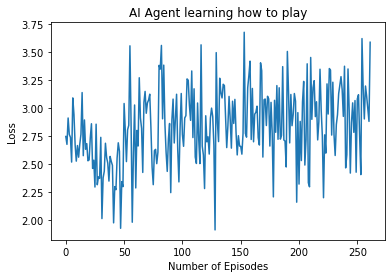

In [21]:
fig = plt.figure()
plt.plot( [i for i in range(len(agent_loss))], agent_loss)
plt.xlabel('Number of Episodes')
plt.ylabel('Loss')
plt.title('AI Agent learning how to play')

In [23]:
np.savetxt('.//v2_models/data-5-1000E_128BS.csv', agent_loss, delimiter=',')

In [108]:
env = Environment()
env.reset()
env.start()
time.sleep(2)
env.jump()
print(f"Episode ended? {env.is_crashed()}")
env.jump()
#images = env.get_screenshot()
#print(images.shape)
#env.view_screenshots(images)
time.sleep(2)
env.duck()
time.sleep(2)
#images = env.get_screenshot()
env.close_all()

D:\Programming\Python\Environments\py3.7_envs\AiPlaysDino\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: use options instead of chrome_options
  


Episode ended? False
Score is 22
Score is 33
Score is 43
Score is 51
Score is 51
Score is 51
Score is 51
Score is 51
Score is 51
Score is 51
Score is 51
Score is 51
Score is 51
Score is 51
Score is 51
Score is 51
Score is 51
Score is 51
Score is 51
Score is 51
Score is 51
Score is 51
Score is 51
Score is 51
Score is 51
No tasks found!


In [41]:
np.savetxt('.//data6-500E.csv', agent_loss, delimiter=',')

Text(0.5, 1.0, 'AI Agent learning how to play')

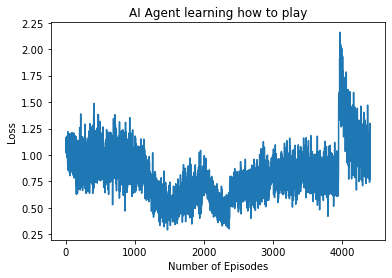

In [42]:
a1 = np.genfromtxt('.//v2_models/data_1000E_128BE.csv', delimiter=',')
a2 = np.genfromtxt('.//v2_models/data-2-1000E_128BS.csv', delimiter=',')
a3 = np.genfromtxt('.//v2_models/data-4-1000E_128BS.csv', delimiter=',')
a4 = np.genfromtxt('.//v2_models/data-5-1000E_128BS.csv', delimiter=',')
a5 = np.genfromtxt('.//v2_models/data6-500E.csv', delimiter=',')
a2 = np.append(a1, a2)
a3 = np.append(a2, a3)
a4 = np.append(a3, a4)
a5 = np.append(a4, a5)
#a5 = np.append(a4, a3)
fig = plt.figure()
plt.plot( [i for i in range(len(a5))], a5)
plt.xlabel('Number of Episodes')
plt.ylabel('Loss')
plt.title('AI Agent learning how to play')

In [40]:
epsilon_trend[-1]


0.9655206468094844

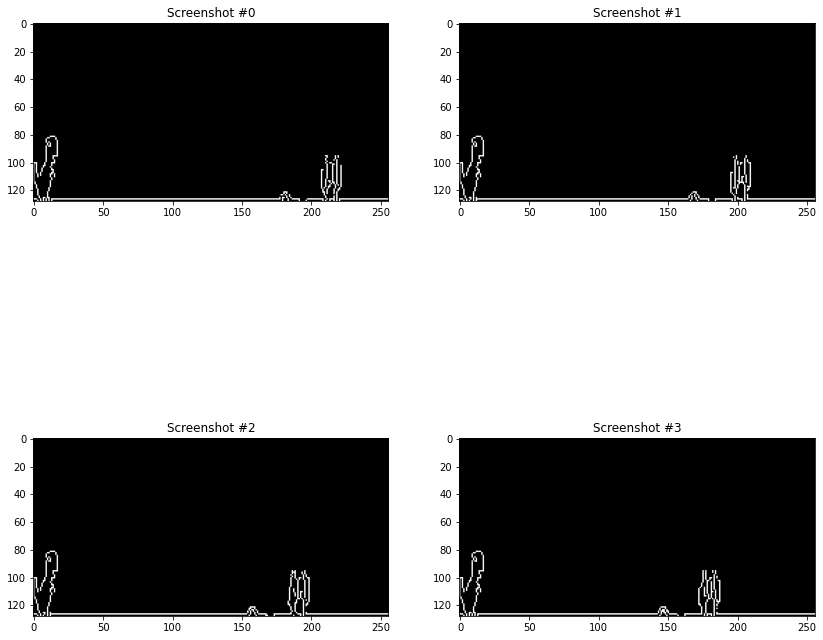

In [49]:
env.view_screenshots(replay_memory[4][0].cpu())

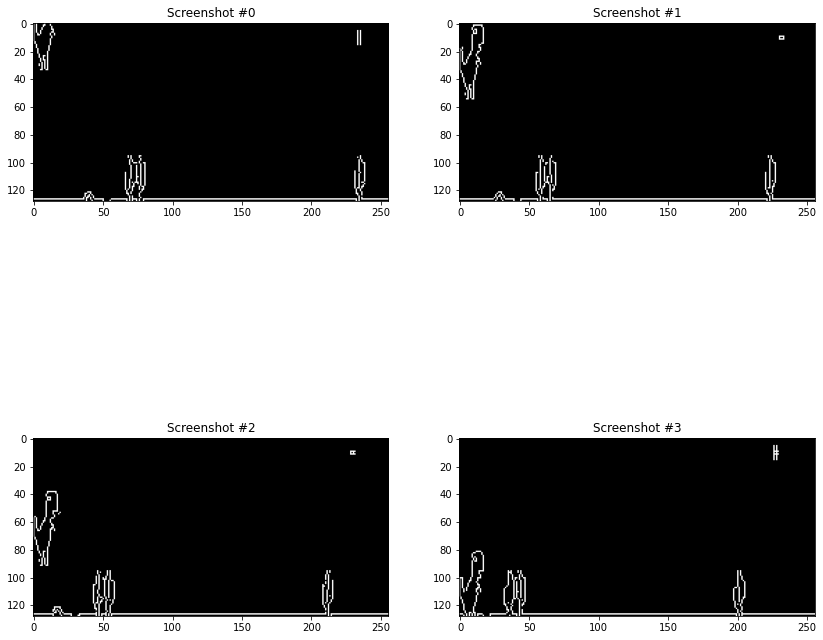

In [48]:
env.view_screenshots(replay_memory[3][3].cpu())